## Installing requirements

In [20]:
!sudo apt install -y tesseract-ocr
!pip install pytesseract transformers datasets seqeval tensorboard evaluate --upgrade


'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
# !pip install -q git+https://github.com/huggingface/transformers.git
# ! pip install -q git+https://github.com/huggingface/datasets.git "dill<0.3.5" seqeval

In [15]:
# !rm -r layoutlmv3FineTuning
# !git clone -b master https://github.com/UBIAI/layoutlmv3FineTuning.git

In [16]:
#!/bin/bash
IOB_DATA_PATH = "C:\\Users\\baran\\Downloads\\dataset1"
destination_path = "C:\\Users\\baran\\Downloads\\dataset1\\data\\"
!cp -r "$IOB_DATA_PATH" "$destination_path"

'cp' is not recognized as an internal or external command,
operable program or batch file.


## Preprocessing the files for LiLT model

In [92]:
#!/bin/bash
#preprocessing args
TEST_SIZE = 0.2
DATA_OUTPUT_PATH = "C:\\Users\\baran\\Downloads\\dataset1"

In [22]:

import os
import argparse
from PIL import Image
from sklearn.model_selection import train_test_split
image_path="'C:\\Users\\baran\\Downloads\\dataset6\\images"
input_path="'C:\\Users\\baran\\Downloads\\dataset6\\images"
output_path="C:\\Users\\baran\\Downloads\\dataset6\\preprocessed"

def convert_to_yolo_format(image_path, bbox_list, class_list, output_file):
    img = Image.open(image_path)
    width, height = img.size

    with open(output_file, 'w') as f:
        for bbox, cls in zip(bbox_list, class_list):
            x_center = (bbox[0] + bbox[2]) / (2 * width)
            y_center = (bbox[1] + bbox[3]) / (2 * height)
            bbox_width = (bbox[2] - bbox[0]) / width
            bbox_height = (bbox[3] - bbox[1]) / height
            line = f"{cls} {x_center} {y_center} {bbox_width} {bbox_height}\n"
            f.write(line)
def preprocess_dataset(input_path, output_path, test_size):
    image_folder = input_path
    image_files = os.listdir(image_folder)

    # Split dataset into train and validation sets
    train_files, valid_files = train_test_split(image_files, test_size=test_size, random_state=42)

    # Create directories for train and validation sets
    os.makedirs(os.path.join(output_path, 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'valid'), exist_ok=True)

    # Process train set
    for file in train_files:
        image_path = os.path.join(image_folder, file)
        bbox_list = []
        class_list =[]
        yolo_txt_path = os.path.join(output_path, 'train', file.replace('.jpg', '.txt'))
        convert_to_yolo_format(image_path, bbox_list, class_list, yolo_txt_path)

    # Process validation set
    for file in valid_files:
        image_path = os.path.join(image_folder, file)
        bbox_list = []
        class_list = []
        yolo_txt_path = os.path.join(output_path, 'valid', file.replace('.jpg', '.txt'))
        convert_to_yolo_format(image_path, bbox_list, class_list, yolo_txt_path)


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('C:\\Users\\baran\\Downloads\\dataset6\\images', help='Path to the input dataset folder')
    parser.add_argument('C:\\Users\\baran\\Downloads\\dataset6\\preprocessed', help='Path to save the preprocessed dataset')
    parser.add_argument('0.2', type=float, default=0.2, help='Validation set size (between 0 and 1)')

In [3]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [38]:
from datasets import load_metric
from transformers import TrainingArguments
from transformers import Trainer
from transformers import LayoutLMv3ForTokenClassification
from transformers import AutoProcessor
from transformers import default_data_collator
from transformers.data.data_collator import default_data_collator
import torch

In [4]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [34]:
# load datasets
from datasets import load_from_disk
train_dataset ="C://Users//baran//Downloads//datset6//images"
eval_dataset = "C://Users//baran//Downloads//datset6//labels"


Dataset({
    features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
    num_rows: 168
})

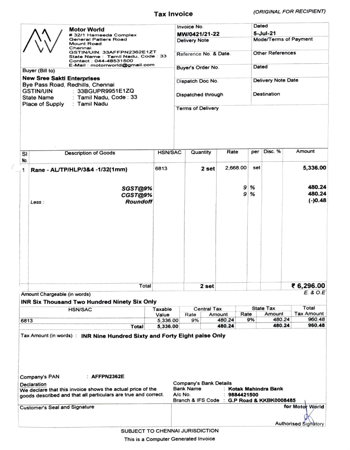

In [25]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("C:\\Users\\baran\\Downloads\\dataset6\\images\\a55e8745-invoice3.jpg")
image = image.convert("RGB")
image.resize((350,450))


In [35]:
label_list = ["Buyer address","Seller address","Invoice No","Invoice Date","GST rate","Buyer GSTIN/UIN","Seller GSTIN/UIN","Buyer State Name","Seller State name","product","HSN/SAC","Quantity",
"Product rate","Product amount","CGST,SGST","State Tax","Central Tax","Total Amount","Tax amount","Company Bank name","Company Bank A/C NO","Company Bank Branch and IFS",
"Company PAN","Product tax","SI No","Seller Ph No","Seller email","Declaration","Signature","Buyer place"]
num_labels = len(label_list)
label2id, id2label = dict(), dict()
for i, label in enumerate(label_list):
    label2id[label] = i
    id2label[i] = label


In [36]:
from transformers import LiltForTokenClassification

# huggingface hub model id
model_id = "SCUT-DLVCLab/lilt-roberta-en-base"

# load model with correct number of labels and mapping
model = LiltForTokenClassification.from_pretrained(
    model_id, num_labels=len(label_list), label2id=label2id, id2label=id2label
)


Some weights of LiltForTokenClassification were not initialized from the model checkpoint at SCUT-DLVCLab/lilt-roberta-en-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Defining metric for evaluation of LiLT model

In [39]:
metric = load_metric("seqeval")
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels,zero_division='0')
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

C:\Users\baran\AppData\Local\Temp\ipykernel_27668\2022220993.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [ ]:
pip install seqeval

  Using cached seqeval-1.2.2.tar.gz (43 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 8.3/8.3 MB 10.0 MB/s eta 0:00:00
     ---------------------------------------- 42.2/42.2 MB 7.2 MB/s eta 0:00:00
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16189 sha256=f1f9a9c577c1e7b6aa7e5adb216ee8979952c9df0239c4fe74e747dbaaf6adcd
  Stored in directory: c:\users\baran\appdata\local\pip\cache\wheels\ad\5c\ba\05fa33fa5855777b7d686e843ec07452f22a66a138e290e732
Successfully built seqeval
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install transformers[torch]

  Using cached transformers-4.30.2-py3-none-any.whl (7.2 MB)
     -------------------------------------- 268.1/268.1 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 3.5/3.5 MB 17.0 MB/s eta 0:00:00
     ------------------------------------- 263.9/263.9 kB 15.9 MB/s eta 0:00:00
  Using cached torch-2.0.1-cp38-cp38-win_amd64.whl (172.4 MB)
  Using cached accelerate-0.20.3-py3-none-any.whl (227 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install accelerate>=0.20.1

Note: you may need to restart the kernel to use updated packages.


Error processing line 1 of c:\Users\baran\AppData\Local\Programs\Python\Python39\lib\site-packages\vision-1.0.0-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "c:\Users\baran\AppData\Local\Programs\Python\Python39\lib\site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


### TRAINING OF LiLT Model

In [42]:
from transformers import Trainer, TrainingArguments
NUM_TRAIN_EPOCHS = 50
PER_DEVICE_TRAIN_BATCH_SIZE = 8
PER_DEVICE_EVAL_BATCH_SIZE = 8
LEARNING_RATE = 4e-5
training_args = TrainingArguments(output_dir="C:\\Users\\baran\\Downloads\\dataset6\\LiLT_INVOICE",
                                  num_train_epochs=NUM_TRAIN_EPOCHS,
                                  logging_strategy="epoch",
                                  save_total_limit=1,
                                  per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
                                  per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
                                  learning_rate=LEARNING_RATE,
                                  evaluation_strategy="no",
                                  save_strategy="no",
                                  # eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)


In [43]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

7475

In [44]:
# Start training
trainer.train()


c:\Users\baran\Downloads\vgtsdata\.conda\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/300 [00:00<?, ?it/s]

TypeError: vars() argument must have __dict__ attribute

### Evaluation Of LiLT Model

In [45]:
trainer.evaluate()


TypeError: vars() argument must have __dict__ attribute

### Saving Trained Model

In [46]:
trainer.save_model('C:\\Users\\baran\\Downloads\\dataset6\\LiLT_Model')

### Inference using Fine-Tuned LiLT Model

In [55]:
from transformers import LiltForTokenClassification, LayoutLMv3Processor
from transformers import LayoutLMv3FeatureExtractor, AutoTokenizer, LayoutLMv3Processor
from PIL import Image, ImageDraw, ImageFont
import torch

# load model and processor from huggingface hub
model = LiltForTokenClassification.from_pretrained("C:\\Users\\baran\\Downloads\\dataset6\\LiLT_Model")


model_id="SCUT-DLVCLab/lilt-roberta-en-base"

# use LayoutLMv3 processor without ocr since the dataset already includes the ocr text
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=True) # set
tokenizer = AutoTokenizer.from_pretrained(model_id)
# cannot use from_pretrained since the processor is not saved in the base model
processor = LayoutLMv3Processor(feature_extractor, tokenizer)



# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]
label2color = {
    'Buyer address':"Red",
    'Seller address':"Orange",
    'Invoice No':"Pink",
    'Invoice Date':"Green",
    'GST rate':"Blue",
    'Buyer GSTIN/UIN':"Brown",
    'Seller GSTIN/UIN':"Violet",
    'Buyer State Name':"Brown",
    'Seller State name':"Yellow",
    'product':"Pink",
    'HSN/SAC':"Red",
    'Quantity':"Violet",
    'Product rate':"Green",
    'Product amount':"Pink",
    'CGST,SGST':"Red",
    'State Tax':"Violet",
    'Central Tax':"Blue",
    'Total Amount':"Green",
    'Tax amount':"Blue",
    'Company Bank name':"Orange",
    'Company Bank A/C NO':"Violet",
    'Company Bank Branch and IFS':"Brown",
    'Company PAN':"Pink",
    'Product tax':"Green",
    'SI No':"Blue",
    'Seller Ph No':"Red",
    'Seller email':"Orange",
    'Declaration':"Violet",
    'Signature':"Brown",
    'Buyer place':"Red"
    }

# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


def run_inference(image, model=model, processor=processor, output_image=True):
    # Create model input
    encoding = processor(image, return_tensors="pt", padding=True, truncation=True)
    input_ids = encoding["input_ids"]
    attention_mask = encoding["attention_mask"]
    bbox = encoding["bbox"]
    ocr_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Run inference
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()

    labels = [model.config.id2label[prediction] for prediction in predictions]

    label_text_dict = {}
    for label, box in zip(labels, bbox[0]):
        start_index = box[0]
        end_index = box[1]
        label_tokens = ocr_tokens[start_index:end_index + 1]
        label_text = tokenizer.convert_tokens_to_string(label_tokens)
        label_text_dict[label] = label_text

    print(label_text_dict)

    if output_image:
        return draw_boxes(image, bbox[0], labels)
    else:
        return labels, label_text_dict







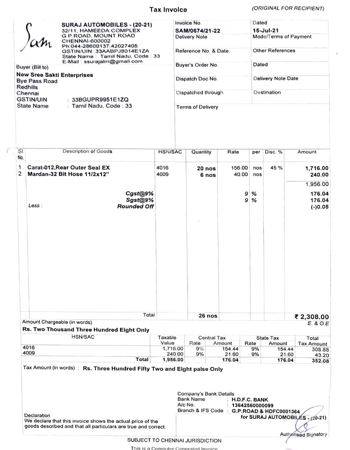

In [56]:
from PIL import Image, ImageDraw, ImageFont
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'D:\\Tesseract\\tesseract.exe'
image = Image.open("C:\\Users\\baran\\Downloads\\dataset6\\images\\63c67225-invoice5.jpg")
image = image.convert("RGB")
image.resize((350,450))

{'CGST,SGST': '32 Bit Hose 11/2x12" 4009 6 nos 40.00 nos 240.00 1,956.00 Cgst@9% 9% 176.04 Sgst@9% 9% 176.04 Less Rounded Off (-)0.08 Total 26 nos % 2,308.00 Amount Chargeable (in words) E&OE Rs. Two Thousand Three Hundred Eight Only HSN/SAC Taxable Central Tax State Tax Total Value Rate Amount _|_Rate | Amount Tax Amount 4016 | 1,716.00/ 9% 154.44 9% 154.44 308.88 4009 240.00, 9% 21.60, 9%. 21.60 __ 43.20 Total! 4,956.00 176.04 176.04 352.08 Tax Amount (In words) : Rs. Three Hundred Fifty Two and Elght paise Only Company\'s Bank Details Bank Name : H.D.F.C. BANK Alc No. + 13642560000099 Branch & IFS Code : G.P.ROAD & HDFC0001364 Declaration for SURAJ AUTOMOBI (20-21) We declare that this invoice shows the actual</s>', 'Tax amount': '<s>', 'HSN/SAC': '', 'Central Tax': '', 'Invoice Date': ' : G.P.ROAD & HDFC0001364 Declaration for SURAJ AUTOMOBI (20-21) We declare that this invoice shows the actual</s>', 'Declaration': ' invoice shows the actual</s>', 'Product tax': '_Rate | Amount Tax

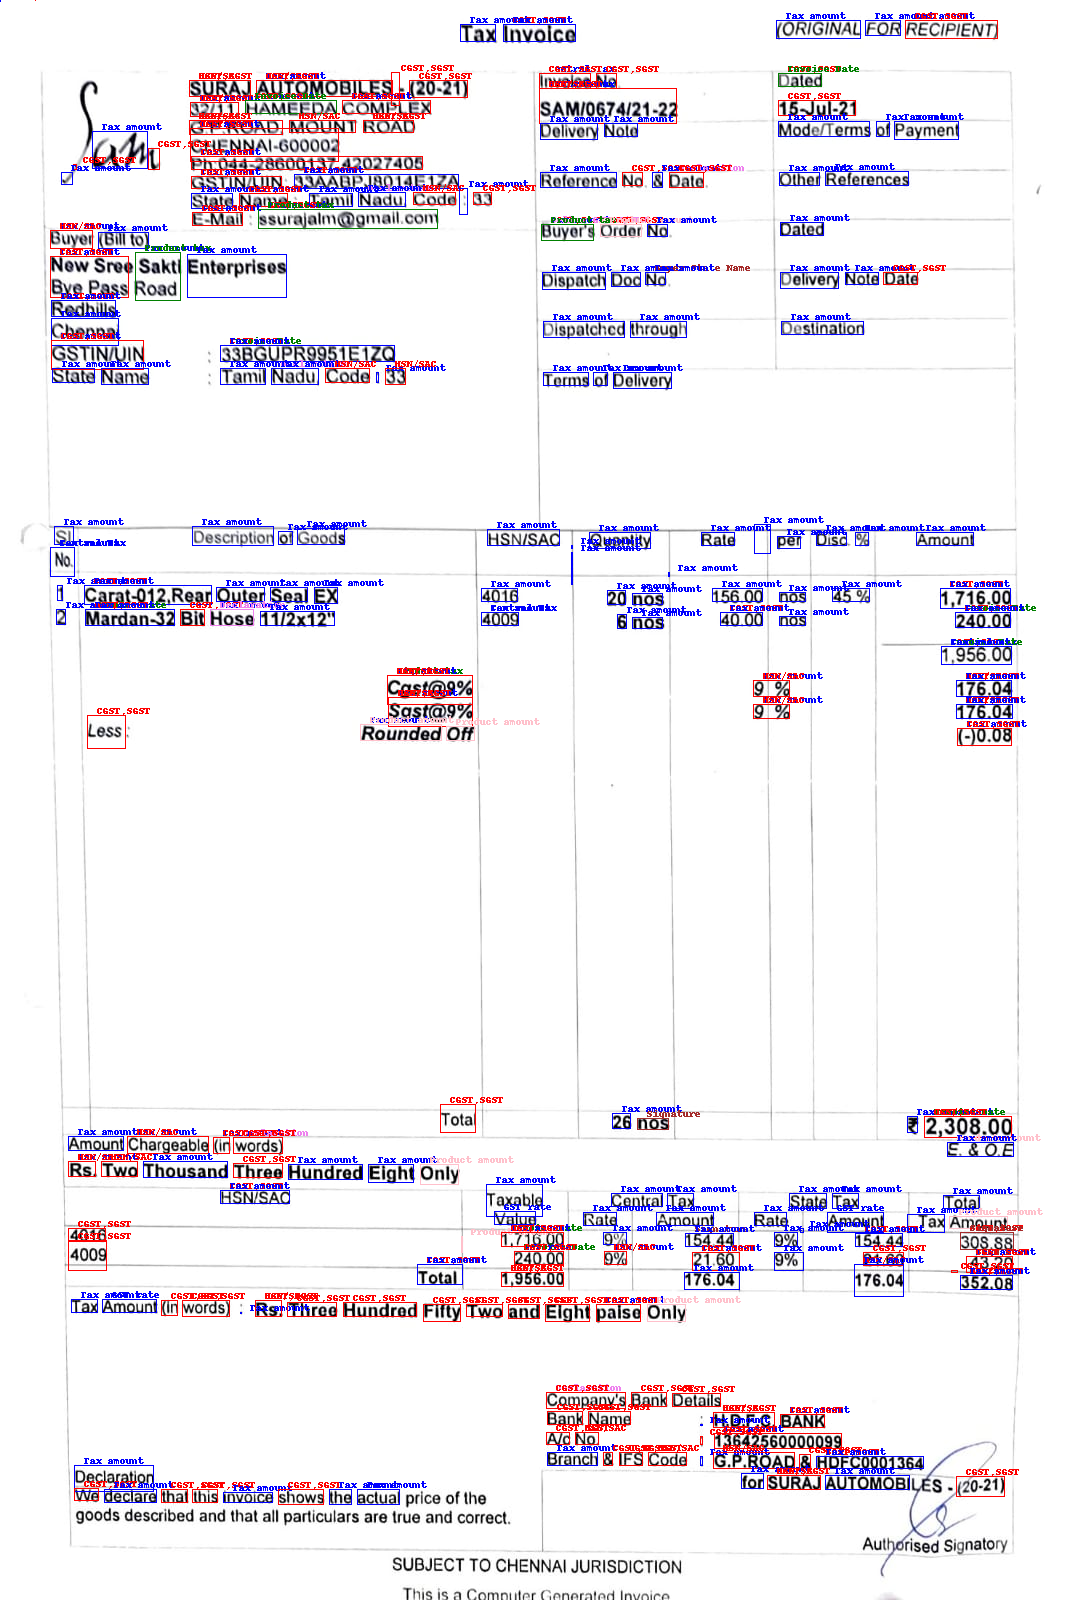

In [57]:

run_inference(image)
